## TOPIC Identification of Mathematical word problems
- In this model , we cluster similar problems using count vectorizer and tfidf vectorizer

### Read the DeepMind AQUA Data Set (.json file)

In [1]:
import pandas as pd
import numpy as np
import json 

import nltk
import string

In [2]:
qb =  pd.read_json('AQuA-master/dev.json',lines=True)
qb.columns

Index(['correct', 'options', 'question', 'rationale'], dtype='object')

In [3]:
qb.head()

,correct,options,question,rationale
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ..."
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's..."


### Functions to remove the named entities 

In [4]:
def untokenize(tokens):
    return("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip())

def extract_nonentities(tree):
    tokens = [leaf[0] for leaf in tree if type(leaf) != nltk.Tree]
    return(untokenize(tokens))

def ne_removal(text_list):
    token_list = [nltk.word_tokenize(text) for text in text_list]
    tagged = nltk.pos_tag_sents(token_list)
    chunked = nltk.ne_chunk_sents(tagged)
    non_entities = []
    for tree in chunked:
        non_entities.append(extract_nonentities(tree))
    return(non_entities)

In [5]:
# removal of named entities
qb['qn'] = ne_removal(qb['question'])


### Text Pre Processing 

In [6]:
## remove numerals , replace % with percent and convert to lowercase
import re
qb.qn = qb.qn.apply(lambda x: x.lower())
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\%', 'percent', x))
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\d+', '', x))

print(qb.qn.iloc[:3])

0    three birds are flying at a fast rate of  kilo...
1    a ship is leaving a port. it takes  seconds to...
2    a rectangular piece of cloth  feet wide was cu...
Name: qn, dtype: object


### Convert Text to Vector Space using Bag-of-words / Count Vectorizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(qb.qn) #train and get bag of words
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)))


Vocabulary size: 1550


In [8]:
bow.shape

(254, 1550)

### Clustering using K-means and optimal clsuter size using distortion/silhouette score 

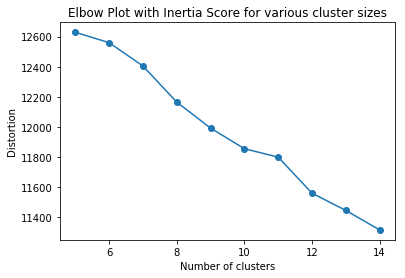

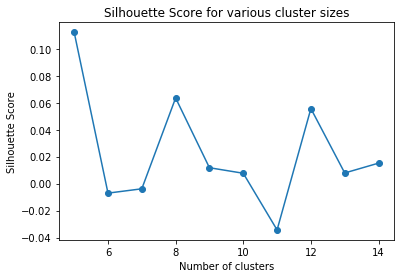

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

sil_scores = []
distortions = []
for i in range (5,15):
    km = KMeans(n_clusters=i,random_state=10,verbose=0)
    Y = km.fit_predict(bow)
 
    distortions.append(km.inertia_)
    if (i>=2):
        sc = (metrics.silhouette_score(bow, Y))
        sil_scores.append(sc)

plt.plot(range(5,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Plot with Inertia Score for various cluster sizes")
plt.show()


plt.plot(range(5,15), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score for various cluster sizes")
plt.show()

In [10]:
questions=qb.question

In [11]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

### Convert Text to Vector Space using TFIDF Vectorizer

In [12]:
# Instantiate the TFIDF vectorizer
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    max_features=30000)

# fit and transform on it the training features
tfidf_matrix = word_vectorizer.fit_transform(qb.qn)

print(tfidf_matrix.shape)

(254, 1381)


In [13]:
terms = word_vectorizer.get_feature_names()
#print(terms)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

[[ -2.22044605e-16   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00  -2.22044605e-16   9.61554447e-01 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   9.61554447e-01  -2.22044605e-16 ...,   1.00000000e+00
    1.00000000e+00   9.43485729e-01]
 ..., 
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,  -2.22044605e-16
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
   -2.22044605e-16   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   9.43485729e-01 ...,   1.00000000e+00
    1.00000000e+00  -2.22044605e-16]]


### Clustering using K-means and optimal clsuter size using distortion/silhouette score 

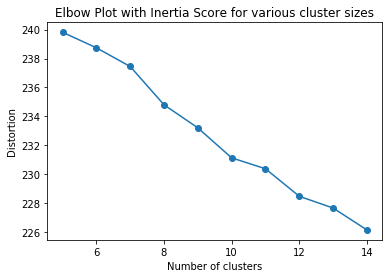

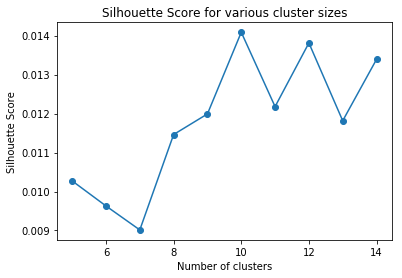

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

sil_scores = []
distortions = []
for i in range (5,15):
    km = KMeans(n_clusters=i,random_state=10,verbose=0)
    Y = km.fit_predict(tfidf_matrix)
 
    distortions.append(km.inertia_)
    if (i>=2):
        sc = (metrics.silhouette_score(tfidf_matrix, Y))
        sil_scores.append(sc)

plt.plot(range(5,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Plot with Inertia Score for various cluster sizes")
plt.show()


plt.plot(range(5,15), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score for various cluster sizes")
plt.show()

In [16]:
km = KMeans(n_clusters=10,random_state=42,verbose=0)
clusters = km.fit_predict(tfidf_matrix)

### Cluster Analysis 

In [17]:
qset = { 'question': qb.question, 'cluster': clusters }
frame = pd.DataFrame(qset, columns = ['question','cluster'])

In [18]:
frame.head()

,question,cluster
0,Three birds are flying at a fast rate of 900 k...,6
1,A ship is leaving a port. It takes 240 seconds...,0
2,A rectangular piece of cloth 2 feet wide was c...,0
3,"In the xy-coordinate plane, which of the follo...",5
4,A travel company wants to charter a plane to t...,6


In [19]:
frame['cluster'].value_counts()

6    54
1    47
4    29
3    28
5    23
7    20
8    15
0    15
9    13
2    10
Name: cluster, dtype: int64

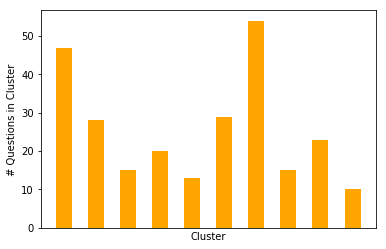

In [20]:
bar_width = 0.5 
plt.bar(frame['cluster'].unique(),frame['cluster'].value_counts(),color='orange',width=bar_width)

plt.xticks([])
plt.xlabel('Cluster')
plt.ylabel('# Questions in Cluster')
plt.show()

### Cluster Analysis - Lets look at the questions in each cluster

In [21]:
grouped = frame['question'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
for key, item in grouped:
    print('-'*80)
    print("Questions in Cluster ",key)
    print('-'*80)
    x = grouped.get_group(key)
    cnt=0
    for i in x:
        print("[",cnt,"]",i)
        cnt=cnt+1;

--------------------------------------------------------------------------------
Questions in Cluster  0
--------------------------------------------------------------------------------
[ 0 ] A ship is leaving a port. It takes 240 seconds to passes through a 750m channel to get to the port gates, and takes 60 seconds to pass through the gates of the port. What is its length?
[ 1 ] A rectangular piece of cloth 2 feet wide was cut lengthwise into two smaller rectangular pieces. The shorter piece was one-third of the length of the longer of the 2 new pieces and had an area of 12 square feet. What was the length Q in feet of the original piece of cloth before cutting?
[ 2 ] A rectangle has twice the area of a square. The length of the rectangle is 14 cm greater than that side of the square whereas breadth is equal to side of the square. Find the perimeter of the square?
[ 3 ] The volume of a wall, 5 times as high as it is broad and 8 times as long as it is high, is 12.8 cubic meters. Find 

### Dimensionality Reduction with SVD

In [22]:
from sklearn.decomposition import TruncatedSVD
svd_m = TruncatedSVD(n_components=2,  algorithm='randomized', n_iter=10, random_state=42)
svd = svd_m.fit_transform(tfidf_matrix)
print(svd.shape)

(254, 2)


In [23]:
d = {"cluster":clusters,"x":svd[:,0],"y":svd[:,1]}
pts=pd.DataFrame(d)
pts.head(10)

,cluster,x,y
0,6,0.061861,0.172964
1,0,0.017393,0.066637
2,0,0.048430,0.062719
3,5,0.032553,0.052516
4,6,0.064251,0.037107
5,1,0.101029,0.016200
6,8,0.199906,-0.074938
7,6,0.020793,0.046490
8,3,0.044526,0.038320
9,2,0.171823,-0.036859


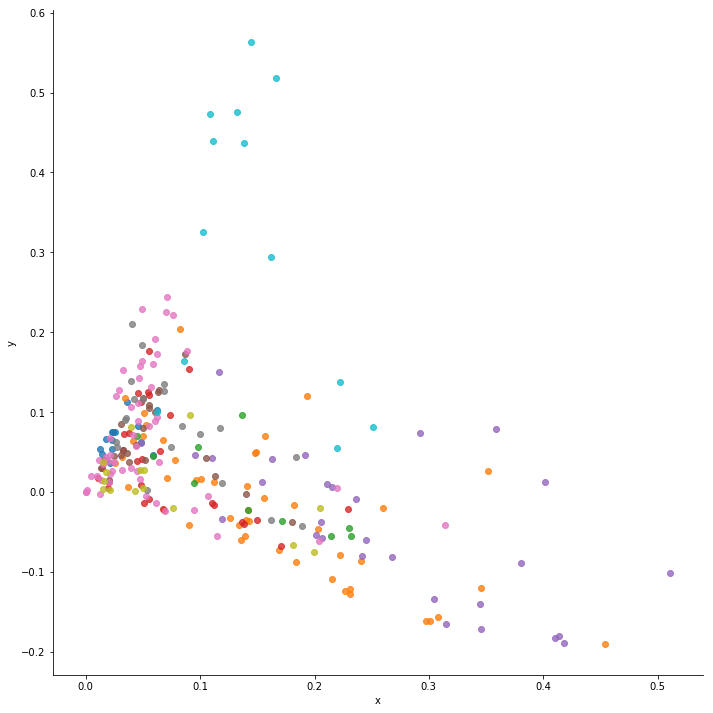

In [25]:
%matplotlib inline
import seaborn as sns
sns.lmplot( x="x", y="y", data=pts, fit_reg=False, hue='cluster', legend=False,size=10, aspect=1)
